In [1]:
#Import libraries & data

exec(open("../python/nb_setup.py").read())#Is there a better way to do this?

from IPython.core.display import display, HTML
from matplotlib.pyplot import *
style.use('../mplstyles/stylelib/standard.mplstyle')


from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
import pickle as pkl
import sys
sys.path.append('../python')
import R68_yield as Yield
import R68_spec_tools as spec
import R68_plot_tools as pt
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.patches as mpatches

#Set up notebook and load some R68 constants (V, eps, etc.)
from constants import *

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Function Definitions

#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

In [3]:
#Now run Sorensen

model_label='Sorensen'
fnames=['data/mcmc_Sor_128walk_50kstep_SNorm_v3.pkl',
        'data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl']

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

In [4]:
#don't vectorize the function below. It already is, vectorizing will lead to bug https://github.com/numpy/numpy/issues/8758
#instead be sure to use np array only for argument!!
ySor = lambda E : Yield.ySor(E,0.151,1.96e-3) 


In [5]:
#extract band info from file. 

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))
    
    if(i==0):
      tight_band=Er_Ycalc_plot
      ytight=Ydist_plot
      cY = ytight<0
      ytight[cY]=0
    else:
      loose_band=Er_Ycalc_plot
      yloose=Ydist_plot
      cY = yloose<0
      yloose[cY]=0


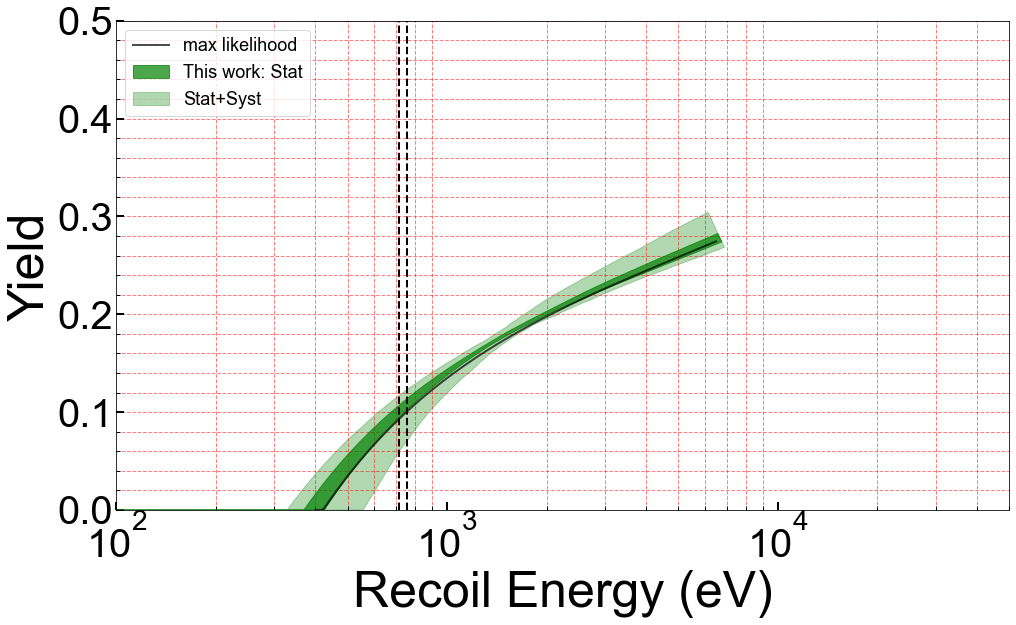

In [6]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))

plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k',linewidth=2)

plt.axvline(754,color='k',linestyle="--")
plt.axvline(715,color='k',linestyle="--")
plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()

In [7]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [8]:
#extract the tight band energies and yields on the high and low side
#vEr is the vector of energies corresponding to those high/low yields
vEr_low_tight=tight_band[0:1001]
vEr_high_tight=tight_band[1001:2002]
vEl_tight=np.zeros(np.shape(vEr_low_tight))
vEmid_tight=np.zeros(np.shape(vEr_low_tight))
vEh_tight=np.zeros(np.shape(vEr_low_tight))
vY_tight=np.zeros(np.shape(vEr_low_tight))
ytight_low = ytight[0:1001]
ytight_high = ytight[1001:2002] 

#because of how the polygon is encoded vEr and ytight_high need
#to be flipped
vEr_high_tight=np.flip(vEr_high_tight)
ytight_high=np.flip(ytight_high)


maxshift=0.0

#calculate the highest and lowest energies that intersect the yield bands at
#a particular yield 
for i,Er_low in enumerate(vEr_low_tight):
    vY_tight[i] = ySor(Er_low)
    
    vEmid_tight[i] = Er_low

    Y,j = find_nearest(ytight_low,vY_tight[i])
    vEh_tight[i] = vEr_low_tight[j]
    Ehigh = vEr_low_tight[j]

    Y,j = find_nearest(ytight_high,vY_tight[i])
   
    vEl_tight[i] = vEr_high_tight[j]
    
    if vEh_tight[i]<vEmid_tight[i]:
        shift = (np.abs(Er_low-vEh_tight[i])/Er_low)
        if (shift > maxshift) & (Er_low>421):
            maxshift=shift
            #print(maxshift,vEmid_tight[i],vEh_tight[i],Ehigh,i,Er_low)
        vEh_tight[i] = vEmid_tight[i]
        

print(vEh_tight[1])
print(maxshift)

print("{0:08.4f}\t{1:08.4f}\t{2:08.4f}".format(vEl_tight[612],vEmid_tight[612],vEh_tight[612]))

33.89473684210527
0.03653800680880666
706.7620	783.3008	783.3008


In [9]:
#extract the tight band energies and yields on the high and low side
#vEr is the vector of energies corresponding to those high/low yields
vEr_low_loose=loose_band[0:1001]
vEr_high_loose=loose_band[1001:2002]
vEl_loose=np.zeros(np.shape(vEr_low_loose))
vEmid_loose=np.zeros(np.shape(vEr_low_loose))
vEh_loose=np.zeros(np.shape(vEr_low_loose))
vY_loose=np.zeros(np.shape(vEr_low_loose))
yloose_low = yloose[0:1001]
yloose_high = yloose[1001:2002] 

#because of how the polygon is encoded vEr and ytight_high need
#to be flipped
vEr_high_loose=np.flip(vEr_high_loose)
yloose_high=np.flip(yloose_high)


#get the mid point yield at a particular energy
#mid = (ytight_low+ytight_high)/2.0

#calculate the highest and lowest energies that intersect the yield bands at
#a particular yield 
#energy points are arbitrary so can use vEr_low_tight here to be sure the vEmid_loose and vEmid_tight are same. 
for i,Er_low in enumerate(vEr_low_tight):
    vY_loose[i] = ySor(Er_low)
   
    vEmid_loose[i] = Er_low

    Y,j = find_nearest(yloose_low,vY_loose[i])
    vEh_loose[i] = vEr_low_loose[j]
   
    Y,j = find_nearest(yloose_high,vY_loose[i])
    
    vEl_loose[i] = vEr_high_loose[j]
    if vEh_loose[i]<vEmid_loose[i]:
        vEh_loose[i] = vEmid_loose[i]


print("{0:08.4f}\t{1:08.4f}\t{2:08.4f}".format(vEl_loose[612],vEmid_loose[612],vEh_loose[612]))

646.5872	783.3008	910.5105


In [10]:
#use existing vectors to create points w/ horizontal errors.

#get a universal energy vector
vErU = vEmid_loose
print(vEmid_loose-vEmid_tight) #both are same b/c used vEr_low_tight in the "loose" loop above
cErange = vErU>424.0
vErU = vErU[cErange] #start where the yield is non-zero

#trim down the vEl and vEh
vEl_looseU = vEl_loose[cErange]
vEh_looseU = vEh_loose[cErange]
vEl_tightU = vEl_tight[cErange]
vEh_tightU = vEh_tight[cErange]
vExerr_looseU = np.asarray([vErU-vEl_looseU,vEh_looseU-vErU])
vExerr_tightU = np.asarray([vErU-vEl_tightU,vEh_tightU-vErU])

#get the yield
vYU = ySor(vErU)

[0. 0. 0. ... 0. 0. 0.]


(667,)
(2, 667)
(34,)
(2, 34)


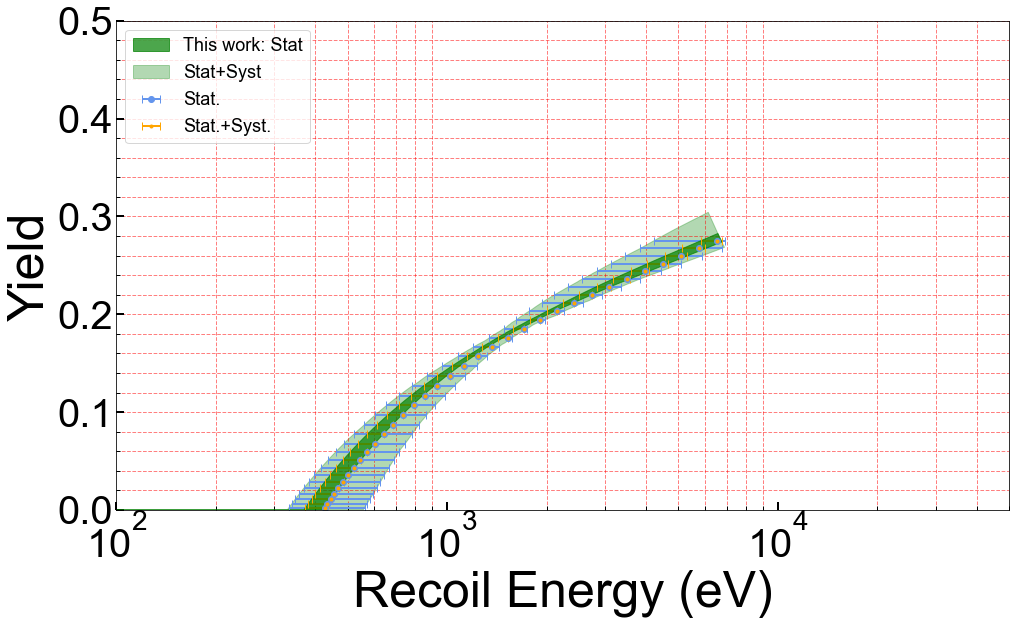

In [11]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))


#plt.axvline(783,color='k',linestyle="--")
#plt.axvline(774,color='k',linestyle="--")
#plt.axvline(706,color='k',linestyle="--")
plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

#plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k')
#plt.plot(np.flip(tight_band[1001:2002]),ytight_high,color="m",linewidth=2)
#plt.plot(tight_band[0:1001],ytight_low,color="m",linewidth=2)

#plt.scatter(vEh_tight[400:1000],vY_tight[400:1000],color='k',marker='s')
#plt.scatter(vEl_tight[400:1000],vY_tight[400:1000],color='b',marker='s')

#plt.scatter(vEh_loose[400:1000],vY_loose[400:1000],color='orange',marker='s')
#plt.scatter(vEl_loose[400:1000],vY_loose[400:1000],color='green',marker='s')

n = 20
print(np.shape(vErU))
print(np.shape(vExerr_looseU))
print(np.shape(vErU[1::n]))
print(np.shape(vExerr_looseU[:,1::n]))

plt.errorbar(vErU[1::n],vYU[1::n],xerr=vExerr_looseU[:,1::n],capsize=4,marker='o',markersize=6,color='cornflowerblue',linestyle='none',label='Stat.')
plt.errorbar(vErU[1::n],vYU[1::n],xerr=vExerr_tightU[:,1::n],capsize=4,marker='o',markersize=3,color='orange',linestyle='none',label='Stat.+Syst.')

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()

In [12]:
#let's do it in close to the xml format

print("\t<data-format>Mathematica</data-format>")
print("\t<data-values>")
print("\t{")

for i,Er in enumerate(vErU):
  
    print("\t{{{0:08.4f},{1:05.4f}}},".format(Er,ySor(Er)))
          
          
print("\t}")
print("\t<data-values>")

	<data-format>Mathematica</data-format>
	<data-values>
	{
	{425.5282,0.0021},
	{425.9187,0.0023},
	{426.3123,0.0025},
	{426.7087,0.0027},
	{427.1082,0.0029},
	{427.5107,0.0031},
	{427.9161,0.0033},
	{428.3247,0.0035},
	{428.7363,0.0038},
	{429.1510,0.0040},
	{429.5688,0.0042},
	{429.9898,0.0044},
	{430.4139,0.0046},
	{430.8413,0.0048},
	{431.2718,0.0050},
	{431.7056,0.0052},
	{432.1426,0.0054},
	{432.5829,0.0057},
	{433.0265,0.0059},
	{433.4735,0.0061},
	{433.9238,0.0063},
	{434.3774,0.0065},
	{434.8345,0.0068},
	{435.2951,0.0070},
	{435.7590,0.0072},
	{436.2265,0.0074},
	{436.6975,0.0077},
	{437.1720,0.0079},
	{437.6500,0.0081},
	{438.1317,0.0083},
	{438.6170,0.0086},
	{439.1059,0.0088},
	{439.5984,0.0090},
	{440.0947,0.0093},
	{440.5947,0.0095},
	{441.0984,0.0098},
	{441.6059,0.0100},
	{442.1173,0.0102},
	{442.6324,0.0105},
	{443.1514,0.0107},
	{443.6743,0.0110},
	{444.2011,0.0112},
	{444.7319,0.0115},
	{445.2666,0.0117},
	{445.8054,0.0120},
	{446.3481,0.0122},
	{446.8950,0.0125},
	{

In [13]:
#let's do it in close to the xml format

print("\t<data-format>Mathematica</data-format>")
print("\t<data-values>")
print("\t{")

for i,Er in enumerate(vErU):
  
    print("\t{{{{{0:08.4f},{1:05.4f}}},0}}".format(vExerr_looseU[0,i],vExerr_looseU[1,i]))
          
          
print("\t}")
print("\t<data-values>")

	<data-format>Mathematica</data-format>
	<data-values>
	{
	{{093.4163,136.8646},0}
	{{093.4534,136.9854},0}
	{{093.4908,137.1072},0}
	{{093.5285,137.2299},0}
	{{093.5665,137.3535},0}
	{{093.6047,137.4781},0}
	{{094.0102,137.6036},0}
	{{094.0518,137.1951},0}
	{{094.0938,137.3184},0}
	{{094.1360,137.4427},0}
	{{094.1786,137.5679},0}
	{{094.2215,137.6941},0}
	{{094.2647,137.8212},0}
	{{094.3083,137.9493},0}
	{{094.3522,138.0783},0}
	{{094.3964,138.2083},0}
	{{094.4410,138.3393},0}
	{{094.4859,138.4712},0}
	{{094.5311,138.0276},0}
	{{094.5767,138.1572},0}
	{{095.0270,138.2878},0}
	{{095.0764,138.4194},0}
	{{095.1261,138.5520},0}
	{{095.1762,138.6855},0}
	{{095.2266,138.8201},0}
	{{095.2775,138.9557},0}
	{{095.3287,139.0923},0}
	{{095.3804,139.2299},0}
	{{095.4324,139.3685},0}
	{{095.4848,139.5082},0}
	{{095.5377,139.0230},0}
	{{095.5909,139.1601},0}
	{{095.6446,139.2982},0}
	{{095.6986,139.4374},0}
	{{095.7531,139.5776},0}
	{{095.8080,139.7188},0}
	{{095.8633,139.8612},0}
	{{096.3746,140.0

In [14]:
#let's do it in close to the xml format

print("\t<data-format>Mathematica</data-format>")
print("\t<data-values>")
print("\t{")

for i,Er in enumerate(vErU):
  
    print("\t{{{{{0:08.4f},{1:05.4f}}},0}}".format(vExerr_tightU[0,i],vExerr_tightU[1,i]))
          
          
print("\t}")
print("\t<data-values>")

	<data-format>Mathematica</data-format>
	<data-values>
	{
	{{052.8820,4.0407},0}
	{{052.8876,4.0711},0}
	{{052.8932,3.6776},0}
	{{052.8989,3.7052},0}
	{{052.9047,3.7331},0}
	{{052.9104,3.7611},0}
	{{052.9163,3.7894},0}
	{{053.3248,3.8179},0}
	{{053.3338,3.8466},0}
	{{053.3428,3.8755},0}
	{{053.3519,3.9046},0}
	{{053.3611,3.9340},0}
	{{053.3703,3.9635},0}
	{{053.3797,3.9933},0}
	{{053.3891,3.5627},0}
	{{053.3985,3.5895},0}
	{{053.4081,3.6165},0}
	{{053.4177,3.6436},0}
	{{053.4275,3.6710},0}
	{{053.4372,3.6985},0}
	{{053.4471,3.7263},0}
	{{053.9008,3.7543},0}
	{{053.9142,3.7824},0}
	{{053.9276,3.8108},0}
	{{053.9412,3.8394},0}
	{{053.9549,3.8682},0}
	{{053.9687,3.8972},0}
	{{053.9826,3.4227},0}
	{{053.9966,3.4484},0}
	{{054.0107,3.4742},0}
	{{054.0249,3.5003},0}
	{{054.0393,3.5265},0}
	{{054.0537,3.5530},0}
	{{054.0683,3.5796},0}
	{{054.0830,3.6064},0}
	{{054.0978,3.6335},0}
	{{054.1128,3.6607},0}
	{{054.6241,3.6881},0}
	{{054.6430,3.7157},0}
	{{054.6620,3.7436},0}
	{{054.6812,3.7716},0}